# Импорт библиотек

In [49]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk import FreqDist, bigrams
from nltk.collocations import BigramCollocationFinder, BigramAssocMeasures
import spacy
import numpy as np
from wordcloud import WordCloud


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Инициализация списка английских стоп-слов и spaCy

In [51]:
nltk_stop_words = set(stopwords.words('english'))
nlp = spacy.load("en_core_web_sm")

# Путь к папке, чтение, предобработка текстов

In [52]:
folder_path = os.path.expanduser(r"/content/drive/My Drive/01_CL_Project_KorbanA/")
text_files = ['text_1.txt', 'text_2.txt', 'text_3.txt', 'text_4.txt', 'text_5.txt']

In [53]:
# Функция для предобработки текста
def preprocess_text(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        text = file.read()

    doc = nlp(text)
    tokens = [(token.lemma_, token.pos_) for token in doc if token.is_alpha and token.lemma_ not in nltk_stop_words]


    return tokens

# Словари для хранения результатов

In [54]:
frequency_dicts = []
bigram_dataframes = []
all_tokens_per_file = []
total_documents = len(text_files)

# Обработка каждого текста (расчеты)

In [55]:

for file_name in text_files:
    full_path = os.path.join(folder_path, file_name)
    tokens = preprocess_text(full_path)
    all_tokens_per_file.append(tokens)

    # Создание частотного словаря с частями речи
    freq_dist = FreqDist([token[0] for token in tokens])
    frequency_data = pd.DataFrame(freq_dist.items(), columns=['Word', 'Frequency'])

    # Определение частей речи
    frequency_data['POS'] = frequency_data['Word'].apply(lambda w: next((token[1] for token in tokens if token[0] == w), None))

    # Расчет TF (Term Frequency)
    total_token_count = sum(freq_dist.values())
    frequency_data['TF'] = frequency_data['Frequency'] / total_token_count

    # Расчет IDF (Inverse Document Frequency)
    word_docs_count = sum(1 for tokens in all_tokens_per_file if frequency_data['Word'].isin([token[0] for token in tokens]).any())
    frequency_data['IDF'] = np.log(np.maximum(total_documents / (word_docs_count + 1e-10), 1))

    # Расчет TF-IDF
    frequency_data['TF-IDF'] = frequency_data['TF'] * frequency_data['IDF']

    # Конвертация значений в строку с форматом не в научной нотации
    frequency_data['TF'] = frequency_data['TF'].apply(lambda x: '{:.10f}'.format(x))
    frequency_data['IDF'] = frequency_data['IDF'].apply(lambda x: '{:.10f}'.format(x))
    frequency_data['TF-IDF'] = frequency_data['TF-IDF'].apply(lambda x: '{:.10f}'.format(x))

    # Добавляем частотный словарь в общий список
    frequency_dicts.append(frequency_data[['Word', 'Frequency', 'POS', 'TF', 'IDF', 'TF-IDF']])

    # Определение биграмм и их частоты
    bigrams_list = list(bigrams([token[0] for token in tokens]))
    bigram_freq = FreqDist(bigrams_list)
    bigram_df = pd.DataFrame(bigram_freq.items(), columns=['Bigram', 'Frequency'])

    # Определение частей речи для биграмм
    bigram_df['POS1'] = bigram_df['Bigram'].apply(lambda bg: next((token[1] for token in tokens if token[0] == bg[0]), None))
    bigram_df['POS2'] = bigram_df['Bigram'].apply(lambda bg: next((token[1] for token in tokens if token[0] == bg[1]), None))
    bigram_df['Relative_Frequency'] = bigram_df['Frequency'] / bigram_df['Frequency'].sum()
    bigram_df['Relative_Frequency'] = bigram_df['Relative_Frequency'].apply(lambda x: '{:.10f}'.format(x))  # Форматирование
    bigram_dataframes.append(bigram_df)


# Биграммы

In [56]:
# Блок анализа биграмм
for i, tokens in enumerate(all_tokens_per_file):
    bigram_measures = BigramAssocMeasures()
    finder_big = BigramCollocationFinder.from_words([token[0] for token in tokens])

    # Использование метрик для оценки биграмм
    scores_lhr = finder_big.score_ngrams(bigram_measures.likelihood_ratio)
    scores_t = finder_big.score_ngrams(bigram_measures.student_t)
    scores_pmi = finder_big.score_ngrams(bigram_measures.pmi)

    # Преобразование метрик в DataFrame
    metrics_df = pd.DataFrame({
        'Bigram': [score[0] for score in scores_lhr],
        'Likelihood_Ratio': [score[1] for score in scores_lhr],
        'Student_t': [score[1] for score in scores_t],
        'PMI': [score[1] for score in scores_pmi],
    })

    # Добавление названия текста в колонку 'Text'
    metrics_df['Text'] = f'text_{i+1}'

    # Ранжирование каждной метрики
    metrics_df['Rank_Likelihood_Ratio'] = metrics_df['Likelihood_Ratio'].rank(ascending=False)
    metrics_df['Rank_Student_t'] = metrics_df['Student_t'].rank(ascending=False)
    metrics_df['Rank_PMI'] = metrics_df['PMI'].rank(ascending=False)

    # Сумма рангов
    metrics_df['Total_Rank'] = metrics_df['Rank_Likelihood_Ratio'] + metrics_df['Rank_Student_t'] + metrics_df['Rank_PMI']

    # Сохранение результата в CSV
    metrics_df.to_csv(os.path.join(folder_path, f'collation_metrics_{i+1}.csv'), index=False)



##Запись в файлы и объединение в сводные файлы

In [57]:
# Объединение всех csv с коллокационными метриками в один
combined_metrics_df = pd.concat([pd.read_csv(os.path.join(folder_path, f'collation_metrics_{i+1}.csv')) for i in range(total_documents)], ignore_index=True)
combined_metrics_df.to_csv(os.path.join(folder_path, 'combined_collation_metrics.csv'), index=False)

# Запись результатов в csv файлы для частотных словарей
for i, freq_df in enumerate(frequency_dicts):
    freq_df.to_csv(os.path.join(folder_path, f'частотный словарь_{i+1}.csv'), index=False)

# Объединение всех частотных словарей в один общий CSV файл
if frequency_dicts:
    combined_frequency_df = pd.concat(frequency_dicts, keys=[f'text_{i+1}' for i in range(total_documents)])
    combined_frequency_df.reset_index(level=0, inplace=True)
    combined_frequency_df.rename(columns={'level_0': 'Text'}, inplace=True)
    combined_frequency_df.to_csv(os.path.join(folder_path, 'общий частотный словарь.csv'), index=False)
else:
    print("Нет данных для объединения частотных словарей.")

# Объединение результатов частиречного анализа биграмм и их относительной частоты
combined_bigram_df = pd.concat(bigram_dataframes, keys=["text_1", "text_2", "text_3", "text_4", "text_5"])
combined_bigram_df.reset_index(level=0, inplace=True)
combined_bigram_df.rename(columns={'level_0': 'Text'}, inplace=True)
combined_bigram_df.to_csv(os.path.join(folder_path, 'all_bigrams.csv'), index=False)

# Визуализации

## Визуализация топ-30 слов

<Figure size 1000x600 with 0 Axes>

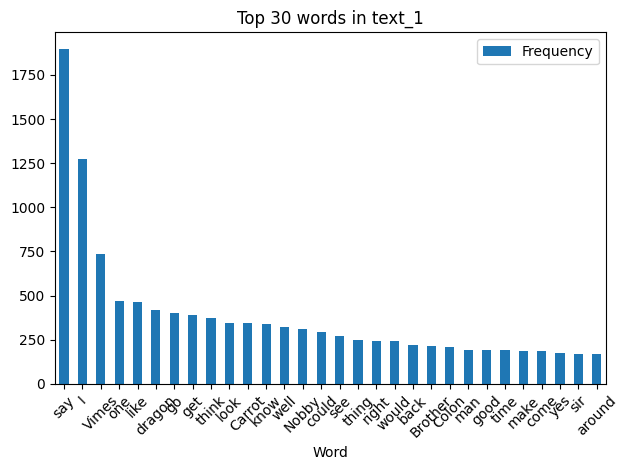

<Figure size 1000x600 with 0 Axes>

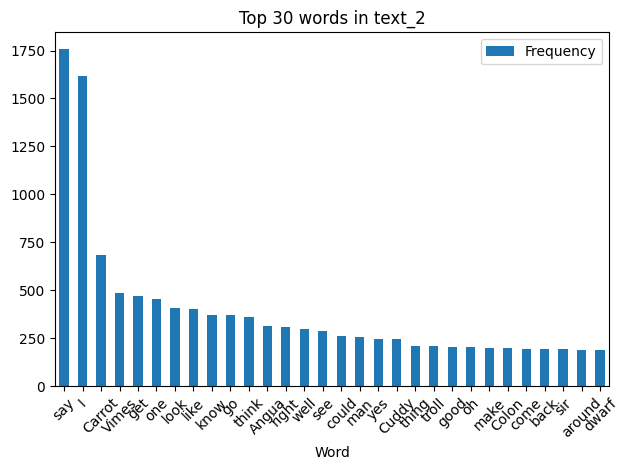

<Figure size 1000x600 with 0 Axes>

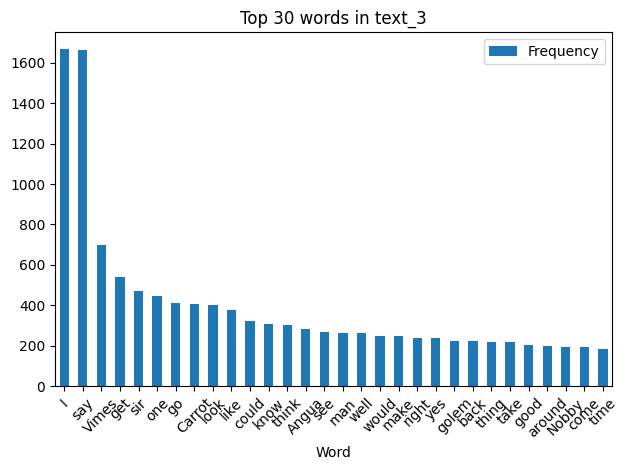

<Figure size 1000x600 with 0 Axes>

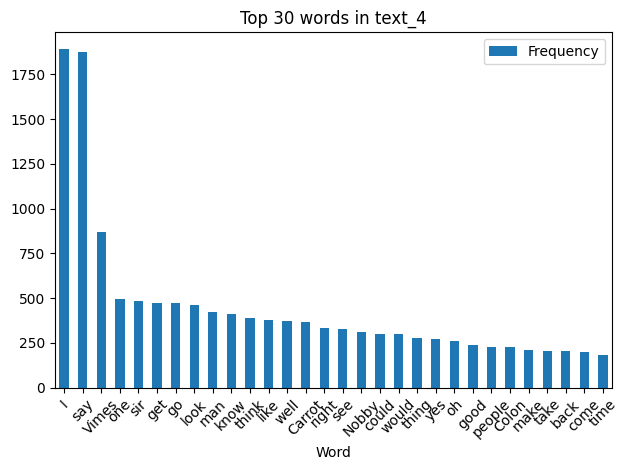

<Figure size 1000x600 with 0 Axes>

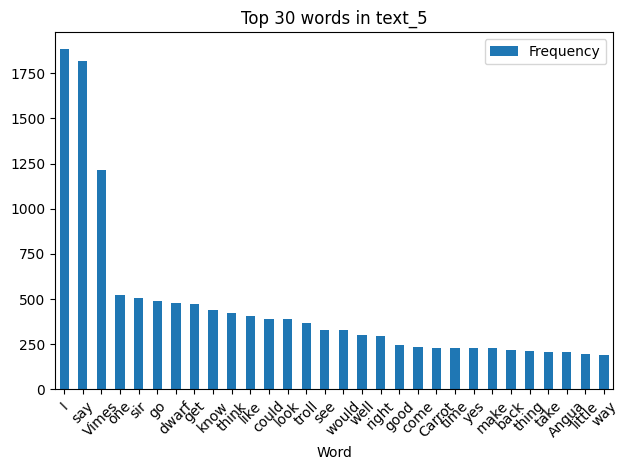

In [47]:
for i, freq_df in enumerate(frequency_dicts):
    plt.figure(figsize=(10, 6))
    freq_df.nlargest(30, 'Frequency').plot(kind='bar', x='Word', y='Frequency')
    plt.title(f'Top 30 words in text_{i+1}')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig(os.path.join(folder_path, f'top_30_words_{i+1}.png'))
    plt.show()

## Облака слов

In [48]:
word_types = ['NOUN', 'ADJ', 'VERB', 'PROPN']
for i, tokens in enumerate(all_tokens_per_file):
    text = ' '.join([token[0] for token in tokens])
    for word_type in word_types:
        wordcloud = WordCloud(max_words=100, background_color='white', colormap='Dark2').generate(' '.join([token[0] for token in tokens if token[1] == word_type]))
        plt.figure(figsize=(10, 6))
        plt.imshow(wordcloud, interpolation="bilinear")
        plt.axis("off")
        plt.title(f'Word Cloud for {word_type}s in text_{i+1}')
        plt.savefig(os.path.join(folder_path, f'word_cloud_{word_type}_{i+1}.png'))
        plt.show()

Output hidden; open in https://colab.research.google.com to view.